In [ ]:
# Step 1: Import necessary libraries and modules
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [ ]:
# Start the timer
start_time = time.time()
df = pd.read_csv(r"/content/Language Detection.csv")
df.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


# Feature ENGINEERING

In [ ]:
# Step 2:  preprocess data
df.Language.replace(to_replace=['Portugeese','Sweedish'],value=['Portuguese','Swedish'],inplace=True)

language= df['Language'].value_counts().reset_index()

import re
def clean_function(Text):
    # removing the symbols and numbers
    Text = re.sub(r'[\([{})\]!@#$,"%^*?:;~`0-9]', ' ', Text)
    
    # converting the text to lower case
    Text = Text.lower()
    Text = re.sub('http\S+\s*', ' ', Text)  # remove URLs
    Text = re.sub('RT|cc', ' ', Text)  # remove RT and cc
    Text = re.sub('#\S+', '', Text)  # remove hashtags
    Text = re.sub('@\S+', '  ', Text)  # remove mentions
    Text = re.sub('\s+', ' ', Text)  # remove extra whitespace
    
    return Text

df['Text'] = df['Text'].apply(lambda x: clean_function(x))

df = df.dropna(subset=['Text', 'Language'])
df = df[['Text', 'Language']]
df = df.groupby('Language').head(700) # select 700 sentences for each language
df['Language'] = df['Language'].astype('category')
num_classes = len(df['Language'].cat.categories)
print("Number of classes: ", num_classes)


Number of classes:  17


In [ ]:
# Step 3: Split data into training, validation, and test sets
train_text, test_text, train_labels, test_labels = train_test_split(df['Text'], df['Language'], test_size=0.2, random_state=42)
train_text, val_text, train_labels, val_labels = train_test_split(train_text, train_labels, test_size=0.2, random_state=42)

In [ ]:
# Step 4: Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
train_seq = tokenizer.texts_to_sequences(train_text)
val_seq = tokenizer.texts_to_sequences(val_text)
test_seq = tokenizer.texts_to_sequences(test_text)
vocab_size = len(tokenizer.word_index) + 1
max_len = 100 # max length of each sentence
train_seq = pad_sequences(train_seq, maxlen=max_len, padding='post')
val_seq = pad_sequences(val_seq, maxlen=max_len, padding='post')
test_seq = pad_sequences(test_seq, maxlen=max_len, padding='post')


In [ ]:
# Step 5: Convert labels to one-hot encoding
train_labels = to_categorical(train_labels.cat.codes, num_classes=num_classes)
val_labels = to_categorical(val_labels.cat.codes, num_classes=num_classes)
test_labels = to_categorical(test_labels.cat.codes, num_classes=num_classes)

In [ ]:
# Step 6: Build and compile the CNN model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          3339100   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 17)                2193      
                                                        

In [13]:
# Step 7: Define the hyperparameters and run GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(num_filters, kernel_size, vocab_size, max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_len))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
param_grid = {'num_filters': [32, 64, 128],
              'kernel_size': [3, 5, 7],
              'vocab_size': [vocab_size],
              'max_len': [max_len]}
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(train_seq[:1000], train_labels[:1000])
#grid_result = grid.fit(train_seq, train_labels)
# Evaluate best hyperparameters on validation set
best_model = create_model(**grid_result.best_params_)
best_model.fit(train_seq, train_labels, epochs=10, batch_size=32, verbose=1)
score = best_model.evaluate(val_seq, val_labels, verbose=1)
print(f"Validation accuracy: {score[1]:.4f}")
print(f"Best score: {grid_result.best_score_:.4f}")
print(f"Best params: {grid_result.best_params_}")

<ipython-input-13-9c1868e2b5a3>:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/10
21/21 [==============================] - 5s 74ms/step - loss: 2.8200 - accuracy: 0.0676
Epoch 2/10
21/21 [==============================] - 1s 65ms/step - loss: 2.7468 - accuracy: 0.1817
Epoch 3/10
21/21 [==============================] - 1s 64ms/step - loss: 2.6301 - accuracy: 0.2643
Epoch 4/10
21/21 [==============================] - 1s 65ms/step - loss: 2.4128 - accuracy: 0.3544
Epoch 5/10
21/21 [==============================] - 1s 65ms/step - loss: 2.0851 - accuracy: 0.4520
Epoch 6/10
21/21 [==============================] - 1s 65ms/step - loss: 1.6593 - accuracy: 0.5991
Epoch 7/10
21/21 [==============================] - 2s 85ms/step - loss: 1.1877 - accuracy: 0.7658
Epoch 8/10
21/21 [==============================] - 2s 87ms/step - loss: 0.7846 - accuracy: 0.8589
Epoch 9/10
21/21 [==============================] - 2s 81ms/step - loss: 0.4979 - accuracy: 0.9339
Epoch 10/10
11/11 [==============================

In [14]:
# Step 8: Evaluate the model on the test set
#test_loss, test_acc = model.evaluate(test_seq, test_labels)
#print("Test accuracy: ", test_acc)
# Step 8: Train the model using the best hyperparameters found by GridSearchCV
best_model = create_model(num_filters=grid_result.best_params_['num_filters'],
                          kernel_size=grid_result.best_params_['kernel_size'],
                          vocab_size=vocab_size,
                          max_len=max_len)  
history = best_model.fit(train_seq, train_labels, epochs=10, batch_size=32, validation_data=(val_seq, val_labels))

# Step 9: Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(test_seq, test_labels)
print("Test accuracy: ", test_acc)


Epoch 1/10
184/184 [==============================] - 23s 118ms/step - loss: 2.2246 - accuracy: 0.3115 - val_loss: 1.0191 - val_accuracy: 0.7223
Epoch 2/10
184/184 [==============================] - 20s 109ms/step - loss: 0.5223 - accuracy: 0.8603 - val_loss: 0.2272 - val_accuracy: 0.9462
Epoch 3/10
184/184 [==============================] - 21s 112ms/step - loss: 0.1030 - accuracy: 0.9758 - val_loss: 0.1608 - val_accuracy: 0.9510
Epoch 4/10
184/184 [==============================] - 20s 106ms/step - loss: 0.0326 - accuracy: 0.9947 - val_loss: 0.1393 - val_accuracy: 0.9578
Epoch 5/10
184/184 [==============================] - 21s 114ms/step - loss: 0.0162 - accuracy: 0.9981 - val_loss: 0.1268 - val_accuracy: 0.9598
Epoch 6/10
184/184 [==============================] - 20s 108ms/step - loss: 0.0116 - accuracy: 0.9983 - val_loss: 0.1256 - val_accuracy: 0.9639
Epoch 7/10
184/184 [==============================] - 21s 113ms/step - loss: 0.0085 - accuracy: 0.9983 - val_loss: 0.1171 - val_ac

In [15]:
# End the timer
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Time taken: {elapsed_time:.2f} seconds")

Time taken: 2232.55 seconds


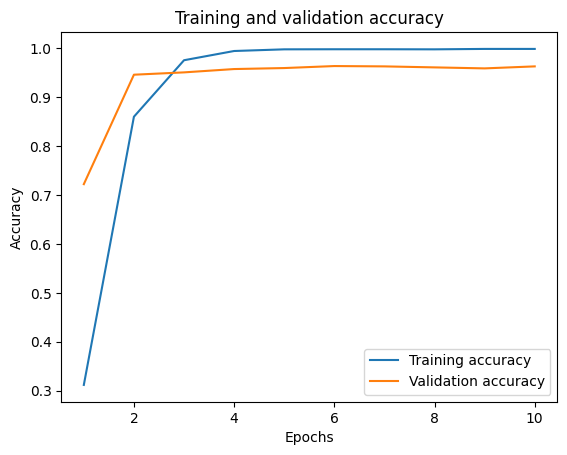

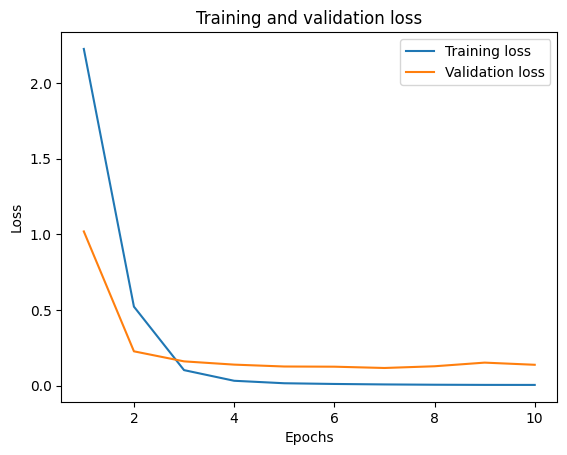

58/58 [==============================] - 1s 14ms/step
Confusion matrix:
 [[ 97   0   0   0   0   0   0   0   0   0   0   0   7   0   0   0   0]
 [  0  81   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0]
 [  1   0 103   0   0   0   0   0   1   0   0   0   2   0   0   0   0]
 [  0   0   0 150   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0 145   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   1   1   0   0  87   0   0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0  71   0   0   0   0   0   2   0   0   0   1]
 [  0   0   0   0   0   0   0  16   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0 134   0   0   3   2   1   0   0   0]
 [  1   0   0   0   0   0   0   0   0  79   0   0   2   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0 103   0   7   0   0   0   0]
 [  0   0   0   0   1   0   0   0   1   0   0 123   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 121   0   0   0   1]
 [  

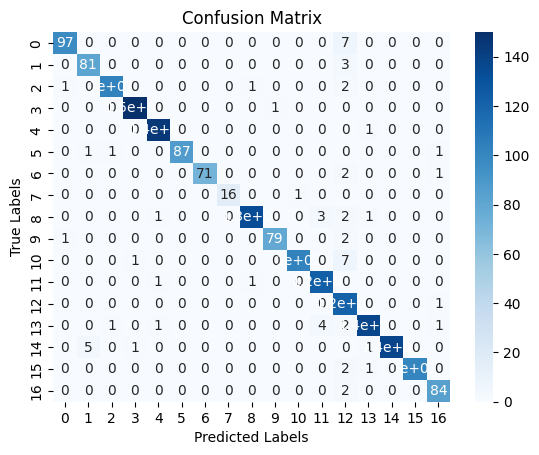

Accuracy: 96.46%
Precision: 97.00%
Recall: 96.29%
F1 score: 96.55%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96       104
           1       0.93      0.96      0.95        84
           2       0.98      0.96      0.97       107
           3       0.99      0.99      0.99       151
           4       0.98      0.99      0.99       146
           5       1.00      0.97      0.98        90
           6       1.00      0.96      0.98        74
           7       1.00      0.94      0.97        17
           8       0.99      0.95      0.97       141
           9       0.99      0.96      0.98        82
          10       0.99      0.93      0.96       111
          11       0.95      0.98      0.96       125
          12       0.80      0.99      0.88       122
          13       0.97      0.94      0.96       147
          14       1.00      0.95      0.98       145
          15       1.00      0.97      0.99 

In [19]:
# Step 10: Generate learning curve diagram
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# Step 11: Generate confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

y_pred = best_model.predict(test_seq)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
confusion_mat = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

print('Confusion matrix:\n', confusion_mat)

import seaborn as sns

# Generate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Recall: {:.2f}%".format(recall*100))
print("F1 score: {:.2f}%".format(f1_score*100))
print("Classification Report:\n", class_report)









